# Imports

In [26]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer, roc_curve

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Lendo Bases

In [7]:
df_train = pd.read_csv('C:/Users/joaov/OneDrive/Área de Trabalho/Python/churn-ml-prod/data/processed/train_data.csv')
df_test = pd.read_csv('C:/Users/joaov/OneDrive/Área de Trabalho/Python/churn-ml-prod/data/processed/test_data.csv')

# Pré-processamento

## Separando Dados

In [8]:
train_data_categ = df_train.select_dtypes(include=['object'])
train_data_num = df_train.select_dtypes(exclude=['object']).drop(['FLAG_CHURN'], axis=1)

## Pipeline de processamento

In [9]:
num_transf = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                             ('scaler', MinMaxScaler())])
cat_transf = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', CatBoostEncoder()),
                             ('scaler', MinMaxScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transf, train_data_num.columns),
        ('cat', cat_transf, train_data_categ.columns)
    ], remainder='drop'
)

prep_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [10]:
x_train, y_train = df_train.drop('FLAG_CHURN', axis=1), df_train['FLAG_CHURN']

x_prep = prep_pipe.fit_transform(x_train, y_train)

# Hyperparameter Tuning

In [17]:
models = {'xgb': XGBClassifier(eval_metric='auc', random_state=42),
          'rf': RandomForestClassifier(random_state=42)}

# Hyperparameter Tuning
params = {
    'xgb': {
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 20),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0)
    },
    'rf': {
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10)
    }
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

grids = {}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary'),
    'auc': make_scorer(roc_auc_score)
}
for model_name, model in models.items():
    grids[model_name] = BayesSearchCV(estimator=model, search_spaces=params[model_name], cv=cv, scoring=scoring, refit='precision', n_jobs=-1, verbose=2)
    grids[model_name].fit(x_prep, y_train)
    
    print(f"\nMelhores resultados para {model_name}:")
    best_index = grids[model_name].best_index_
    results = grids[model_name].cv_results_

    print(f"Melhor combinação de parâmetros: {results['params'][best_index]}")
    for score in scoring:
        mean_score = results[f'mean_test_{score}'][best_index]
        std_score = results[f'std_test_{score}'][best_index]
        print(f"  {score.capitalize()}: Média = {mean_score:.4f}, Desvio Padrão = {std_score:.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
models = {'xgb': XGBClassifier(eval_metric='auc', random_state=42),
          'rf': RandomForestClassifier(random_state=42)}

# Hyperparameter Tuning
params = {
    'xgb': {
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 20),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0)
    },
    'rf': {
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10)
    }
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

grids = {}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary'),
    'auc': make_scorer(roc_auc_score)
}
for model_name, model in models.items():
    grids[model_name] = BayesSearchCV(estimator=model, search_spaces=params[model_name], cv=cv, scoring=scoring, refit='precision', n_jobs=-1, verbose=2)
    grids[model_name].fit(x_prep, y_train)
    
    print(f"\nMelhores resultados para {model_name}:")
    best_index = grids[model_name].best_index_
    results = grids[model_name].cv_results_

    print(f"Melhor combinação de parâmetros: {results['params'][best_index]}")
    for score in scoring:
        mean_score = results[f'mean_test_{score}'][best_index]
        std_score = results[f'std_test_{score}'][best_index]
        print(f"  {score.capitalize()}: Média = {mean_score:.4f}, Desvio Padrão = {std_score:.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [20]:
x_test = prep_pipe.transform(df_test.drop('FLAG_CHURN', axis=1))
y_test = df_test['FLAG_CHURN']

In [21]:
model = grids['rf'].best_estimator_
model.fit(x_prep, y_train)
y_pred_train = model.predict(x_prep)
y_pred_test = model.predict(x_test)

In [23]:
acc_train = precision_score(y_train, y_pred_train)
acc_valid = precision_score(y_test, y_pred_test)
print(f"Precisão treino: {acc_train:.4f}")
print(f"Precisão validação: {acc_valid:.4f}")

Precisão treino: 0.9961
Precisão validação: 0.9223


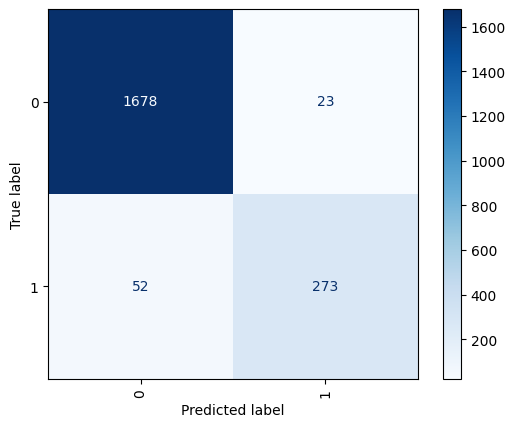

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')

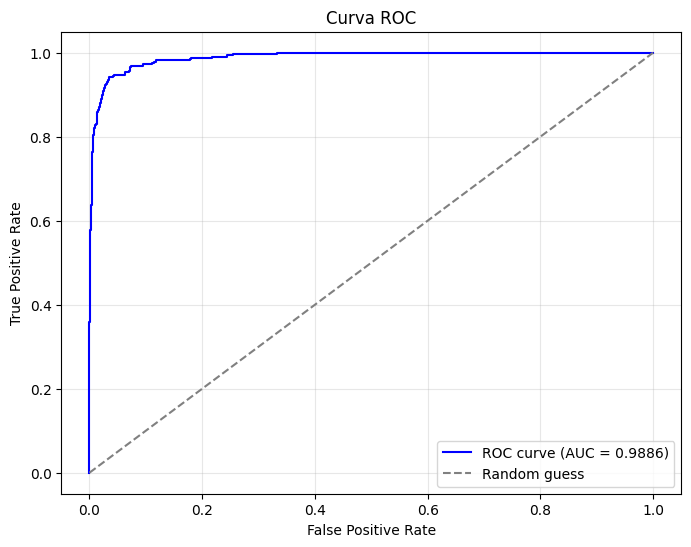

In [27]:
y_pred_proba = model.predict_proba(x_test)[:, 1]

# Calcular pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

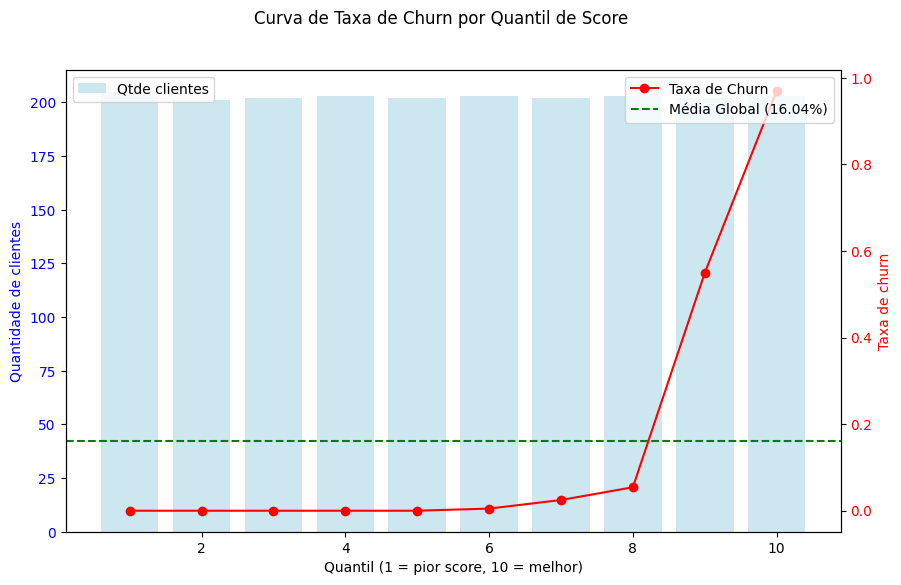

Tabela por quantil:
   quantil  total  churns      rate      lift
0        1    205       0  0.000000  0.000000
1        2    201       0  0.000000  0.000000
2        3    202       0  0.000000  0.000000
3        4    203       0  0.000000  0.000000
4        5    202       0  0.000000  0.000000
5        6    203       1  0.004926  0.030709
6        7    202       5  0.024752  0.154303
7        8    203      11  0.054187  0.337795
8        9    202     111  0.549505  3.425529
9       10    203     197  0.970443  6.049595

KS Statistic: 0.9069


In [29]:
df_test['SCORE_CHURN'] = y_pred_proba
# Garantir que SCORE_CHURN está no df_test
df_test = df_test.copy()
df_test['quantil'] = pd.qcut(df_test['SCORE_CHURN'], 10, labels=False, duplicates="drop") + 1  # 1 = pior, 10 = melhor score

# Agrupar por quantil
grouped = df_test.groupby('quantil').agg(
    total=('FLAG_CHURN', 'count'),
    churns=('FLAG_CHURN', 'sum')
).reset_index()

grouped['rate'] = grouped['churns'] / grouped['total']
global_mean = df_test['FLAG_CHURN'].mean()

# Lift = taxa do grupo / taxa global
grouped['lift'] = grouped['rate'] / global_mean

# --- KS ---
fpr, tpr, thresholds = roc_curve(df_test['FLAG_CHURN'], df_test['SCORE_CHURN'])
ks = max(tpr - fpr)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras (quantidade de clientes)
ax1.bar(grouped['quantil'], grouped['total'], color='lightblue', alpha=0.6, label='Qtde clientes')
ax1.set_xlabel("Quantil (1 = pior score, 10 = melhor)")
ax1.set_ylabel("Quantidade de clientes", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Linha da taxa de churn
ax2 = ax1.twinx()
ax2.plot(grouped['quantil'], grouped['rate'], marker='o', color='red', label='Taxa de Churn')
ax2.axhline(global_mean, color='green', linestyle='--', label=f'Média Global ({global_mean:.2%})')
ax2.set_ylabel("Taxa de churn", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Título e legendas
fig.suptitle("Curva de Taxa de Churn por Quantil de Score")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

# Mostrar tabela com lifts
print("Tabela por quantil:")
print(grouped[['quantil', 'total', 'churns', 'rate', 'lift']])

print(f"\nKS Statistic: {ks:.4f}")

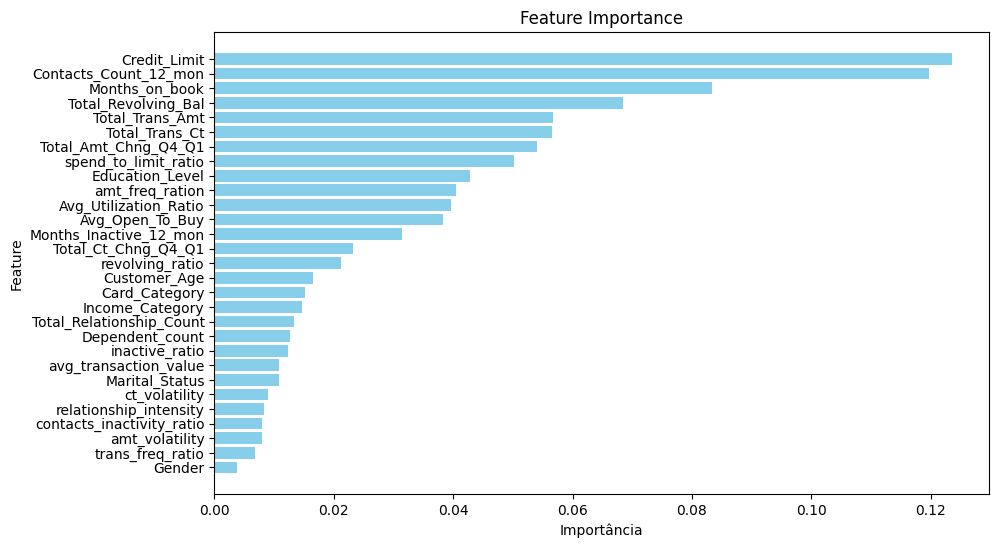

                  feature  importance
11           Credit_Limit    0.123643
10  Contacts_Count_12_mon    0.119755
7          Months_on_book    0.083402
12    Total_Revolving_Bal    0.068495
15        Total_Trans_Amt    0.056640
16         Total_Trans_Ct    0.056582
14   Total_Amt_Chng_Q4_Q1    0.054093
22   spend_to_limit_ratio    0.050215
3         Education_Level    0.042789
21        amt_freq_ration    0.040491


In [38]:
# Pegar importâncias
importances = model.feature_importances_
features = x_train.columns.to_list()  # se você usou pandas DataFrame, fica mais fácil

# Criar dataframe
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color="skyblue")
plt.gca().invert_yaxis()  # maior importância no topo
plt.title("Feature Importance")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()

# Mostrar top 10
print(feat_imp.head(10))

In [ ]:
df_train['Credit']